# Denoise for Image Matrices with Fast Fourier Transformation #

## Team: 

RoxinLiu(rliu227), 
Zhengda Han(zhan66), 
Leon Zhang(jzhang867)

## Abstract:

The purpose of this project is to discuss the application and efficiency of Fast Fourier Transform (FFT) on image denoising. We would first get our hands on the simpliest denoising approach: the Naive inversion solution, which can be corrupted by the noises. We then introduce the idea of Fourier Transform and Discrete Fourier Transform (DFT), an approach that treat image pixels as signal frequencies and is able to filter data at certain frequencies. Due to the high time complexity of DFT, we then analyze FFT in depth, and in particular, the reason FFT is equally correct and even faster than DFT mathematically, specifically in regards to symmetry of the formula. Finally, we will discuss how to apply FFT on image denoising theoretically and practically. After taking the project, the student will be able to:
- Understand concepts of Fouier Transform and FFT.
- Use FFT for image denoising.


## Background:

In brief, given a periodic function of frequency and time, the Fourier Transform serves as a filter for certain frequencies and eliminates the others in the frequency domain (instead of time domain). When such function is a group of people's voices frequency over time, for example, the Fourier Transform can filter voices in high pitch or low pitch, differentiating voices of different genders, even individuals. 

The formula and its inverse looks like this:
\begin{equation*}
F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-j \omega t} dt
\\
f(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} F(\omega) e^{j \omega t} dt
\end{equation*}
in which X(F) is the complex coefficient for a particular frequency F, f(t) is the frequency at time t, j = $\sqrt{-1}$, and $e^{j\theta} = cos\theta + jsin\theta$, the Euler's Formula. This function gives 0 if the mixed frequency does not contain specific frequency $\omega$, and non-zero otherwise. In other words, if certain frequency $\omega$ (at a particular Hz level) makes up a large portion of the mixed frequency, then $F(\omega)$ will be a relatively large value. 

Later, we will talk about the concept of DFT, FFT, and how to apply to image denoising. 

Reference: http://www.cs.cmu.edu/afs/andrew/scs/cs/15-463/2001/pub/www/notes/fourier/fourier.pdf




## Warm-up: the Naive Approach

But first, why would we want to use FFT, a rather difficult way to solve the problem? 

Let's take a look at the Naive Inverse method.
The mathematical model of image formation is:
\begin{equation*}
   b(u, v) = \int\int \! a(u, s, v, t) x(s, t) \mathrm{d}s \mathrm{d}t + e(u, v)
\end{equation*}
In short, we can write: \begin{equation*} b = Ax + e \end{equation*}
where x is the original signal of an image, b is the signal that we observed from devices, e is the noise, A is the distortion applied to the image signal and is defined by the "point spread function": \begin{equation*} a(u,s,v,t) \end{equation*}

The main objective can be simply put as:<br> 
> __Given b and A, compute an approximation of x__

When regarding the noise e, some might wish to simply do a naive inverse problem by putting e and b together.
\begin{equation*} Ax = b + e \Rightarrow x = A^{-1} (b + e) \end{equation*}
Using Singular Value Decomposition of A:
\begin{equation*} A = U\Sigma V^T \end{equation*}
we have the naive solution:
$$ x = A^{-1}(b + e) $$
$$ = V\Sigma U^T(b + e) $$
$$ = \sum_{i=1}^{n} \frac{u_i^T (b + e)}{\sigma_i} v_i $$
$$ = \sum_{i=1}^{n} \frac{u_i^Tb}{\sigma_i} v_i + \sum_{i=1}^{n} \frac{u_i^Te}{\sigma_i} v_i $$
$$ = x + error $$
We can see from the result that this naive inverse solution would produce the original image plus unwanted error signals, which corrupt the final result with __noise__.

We will show this by adding gaussian noise to a clear image.

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

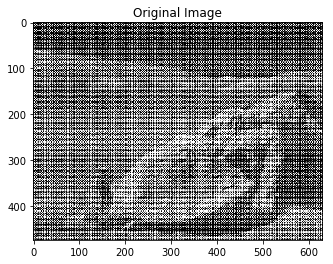

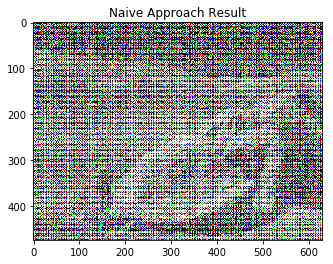

In [2]:
# Reference: https://theailearner.com/2019/05/07/add-different-noise-to-an-image/
def add_gaussian_noise(img):
    # Generate Gaussian noise
    gauss = np.random.normal(0,1,img.size)
    gauss = gauss.reshape(img.shape[0],img.shape[1],img.shape[2]).astype('uint8')
    # Add the Gaussian noise to the image
    img_gauss = cv2.add(img, gauss)
    cv2.imshow('a',img_gauss)
    return img_gauss

img = cv2.imread('./moonlanding.png')

plt.imshow(img)
plt.title('Original Image')
plt.show()

imgn = add_gaussian_noise(img) # img with noise

plt.imshow(imgn)
plt.title('Naive Approach Result')
plt.show()

Therefore, we need a more articulate approach to accomplish our goal -- Fast Fourier Transformation.

## Main Activity

There are 3 issues to be solved:

### Why DFT? 

Most of the time we obtain many data points along the time instead of continuous data. Therefore we can move forward to use the Fast Fourier Transform to solve the Discrete Fourier Transform:
\begin{equation*}
F(k) = \sum_{n=0}^{N-1} f(n) \ e^{-j\ 2\pi k \frac{n}{N}} 
\end{equation*}
for the sample frequency k (each point of frequency over time is a sample), and there are a total of n samples, each with the signal $x_n$.


### Why FFT?  

Fourier Transform has huge time complexity of $n^2$. In order to achieve higher efficiency, behold Fast Fourier Transform. The reason the FFT is faster is that instead of summing up testing for every frequency level for each sample, the FFT uses "Divide and Conquor", separating samples at even and odd indices and solving the same problem with half sample sizes. Let us see how specifically is FFT calculated:

By dividing up samples into the ones with even and odd indices, we have
\begin{equation*}
F(k) = \sum_{n=0}^{N/2-1} f(2n)\ e^{-j\ 2\pi k \frac{2n}{N}} + \sum_{n=0}^{N/2-1} f(2n+1)\ e^{-j\ 2\pi k \frac{2n+1}{N}}
\end{equation*}
where the first term sums the even index analysis, and the second term sums the odd index analysis. By expanding the coefficient of e, the second term can be re-written as 
\begin{equation*}
\left(e^{-j\ 2 \pi k \frac{1}{N}} \right) \sum_{n=0}^{N/2-1} f(2n+1)\ e^{-j\ 2 \pi k \frac{n}{N/2}}
\end{equation*}

##### Activity:
If we only have 2 samples, such separation will give us 2 terms to calculate: the analysis of index 0 and the analysis of index 1. 
Can you write out the complete formulas to find out coefficient for frequency k for both DFT and FFT? 

##### Solution

<details><summary>CLICK THE TRIANGLE TO VIEW</summary>
    
DFT:
\begin{equation*}
F(k) = f(0) + f(1)\ e^{-j\ 2\pi k \frac{1}{N}}
\end{equation*}  
FFT:
\begin{equation*}
F(k) = f(0) + e^{-j\ 2 \pi k \frac{1}{N}} \ f(1)
\end{equation*}

You can see that the two are essentially the same.
Both term have $m = 0$ only, which lead to the term of e being 1. 

##### Activity:
What if we have 4 terms? Can you still write out the DFT and FFT formulas?

##### Solution

<details><summary>CLICK THE TRIANGLE TO VIEW</summary>
    
DFT:
\begin{equation*}
F(k) = f(0) + f(1)\ e^{-j\ 2\pi k \frac{1}{N}} + f(2)\ e^{-j\ 2\pi k \frac{2}{N}} + f(3)\ e^{-j\ 2\pi k \frac{3}{N}}
\end{equation*}  

FFT:
\begin{equation*}
F(k) = \sum_{n=0}^{N/2-1} f(2n)\ e^{-j\ 2\pi k \frac{2n}{N}} + \left(e^{-j\ 2 \pi k \frac{1}{N}} \right) \sum_{n=0}^{N/2-1} f(2n+1)\ e^{-j\ 2 \pi k \frac{n}{N/2}}   
\end{equation*}

Here, each summation has two values of n. We can divide each again, each holding 1 value only:

\begin{equation*}
The\ 1st\ term = \sum_{n=0}^{N/4-1} f(4n)\ e^{-j\ 2\pi k \frac{n}{N/4}} + \left(e^{-j\ 4 \pi k \frac{1}{N}} \right) \sum_{n=0}^{N/4-1} f(4n+2)\ e^{-j\ 2 \pi k \frac{n}{N/4}} \\
The\ 2nd\ term = e^{-j\ 2 \pi k \frac{1}{N}} \left( \sum_{n=0}^{N/4-1} f(4n+1)\ e^{-j\ 2\pi k \frac{n}{N/4}} + \left(e^{-j\ 4 \pi k \frac{1}{N}} \right) \sum_{n=0}^{N/4-1} f(4n+3)\ e^{-j\ 2 \pi k \frac{n}{N/4}} \right)
\end{equation*}

Given only 4 terms, the FFT for k=0 is:

\begin{equation*}
F(0) = f(0) + \left(e^{-j\ 4 \pi k \frac{1}{N}} \right) f(1) + \left(e^{-j\ 2 \pi k \frac{1}{N}} \right) \left( f(2) + \left(e^{-j\ 4 \pi k \frac{1}{N}} \right) f(3) \right) 
\end{equation*}

At this point, it may still seems redundant to do FFT, since you may notice both DFT and FFT formulas are equally long and nasty. What makes FFT more efficient? Here comes the trick: When having a total of N samples along the frequency domain, we will discover the coefficients for each frequency by finding $F(k)$ where $k = 1,2,...,N$. 

Due to spliting, we could also express it as finding $F(k)$ and $F(N/2 + k)$, with $k = 1,2,...,N/2$, assuming N is divisible by 2.
Take a look at the chunk of equation of even indices in $F(N/2 + k)$:

\begin{equation*}
F(N/2 + k) = \sum_{n=0}^{N/2-1} f(2n)\ e^{-j\ 2\pi (N/2+k) \frac{2n}{N/2}} \\
\ = \sum_{n=0}^{N/2-1} f(2n)\ e^{-j\ 4\pi n} \ e^{-j\ 4\pi k \frac{n}{N/2}} \\
\ = \sum_{n=0}^{N/2-1} f(2n)\ e^{-j\ 4\pi k \frac{n}{N/2}} \\
\ = F(k)
\end{equation*}

Similar for the odd-indice chunk. Additionally, the $e$'s power in $F(k)$ and $F(N/2 + k)$ are also the same:

\begin{equation*}
e^{-j\ 2\pi k \frac{n}{N/2}} = e^{-j\ 2\pi \left( N/2+k \right)\frac{n}{N/2}}
\end{equation*}

due to the property of Euler's equation.

This symmetry property is important in that it means we only need to do half of the calculation, and the other half would be the same. 

Reference: https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/

##### Activity:
With that being said, can you predict the time complexity of FFT?

##### Solution

<details><summary>CLICK THE TRIANGLE TO VIEW</summary>
    
$O(N logN)$, much less that the DFT's complexity of $O(N^2)$.

### How to apply to image?

The image can be seen as a function of signal frequencies over pixels, having low frequencies represent the figure's outline and high frequencies represent details. In terms of image, the Fourier Transform is able to retain low frequencies while eliminating frequencies or the reverse, therefore bluring or debluring the image by processing each pixel. 

When processing image, each pixel is identified with 2 indices from the 2 axises, so it is necessary to take the 1-dimensional formula and change into 2 dimensions. In order to do that, we split the 
We can get the formula of Fast Fourier Transform for images being
\begin{equation*}
F(x,y) = \sum_{m=0}^{M-1}\sum_{n=0}^{N-1} f(m,n)\ e^{-j2\pi\left(x\frac{m}{M} + y\frac{n}{N}\right)}\\
f(x,y) = \frac{1}{MN} \sum_{m=0}^{M-1}\sum_{n=0}^{N-1} F(x,y)\ e^\left(j2\pi\left(x\frac{m}{M} + y\frac{n}{N}\right)\right)
\end{equation*}

where the dimension of the image is M and N, f(m,n) is the pixel at coordinates (m,n), and F(x,y) is the frequency corresponding to coordinates x and y.

Reference: https://software.intel.com/en-us/articles/implementation-of-fast-fourier-transform-for-image-processing-in-directx-10

### Image Denoising Demo

After knowing about the principles behind FFT, now let's look at how to use FFT to do image denoising in real code.

For simplicity, here we use a pre-implemented package called 'fftpack' from scipy.org for faster and more accurate result.

The image denoising basically has 4 steps:
    1. Read and import image
    2. Compute 2D FFT of the image, using methods already implemented in fftpack
    3. Filter FFT
        We'll make a copy of the original spectrum and only keep the coefficients in range we accept. Here we set the threshold 
        keep_fraction to be 0.1 and set all indicies from threshold to 1 to be zeros.
    4. Reconstruct the image
        Reconstruct the image using the spectrum we just filtered, keeping only the real part for display.

#### Step 1:
Loading image

Text(0.5,1,'Original image')

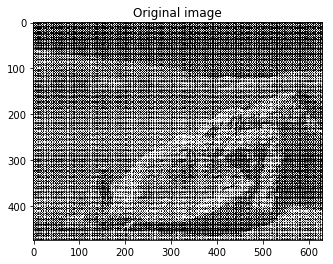

In [3]:
#Step 1
import numpy as np
import matplotlib.pyplot as plt

image = plt.imread('./moonlanding.png').astype(float)

plt.figure()
plt.imshow(image, plt.cm.gray)
plt.title('Original image')

#### Step 2: 
Apply FFT function

In [4]:
#Step 2
from scipy import fftpack

image_fft = fftpack.fft2(image)

keep_fraction = 0.1
image_fft2 = image_fft.copy()
r, c = image_fft2.shape
image_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
image_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0


#### Step 3:
Create the new image with noises removed

Text(0.5,1,'Reconstructed Image')

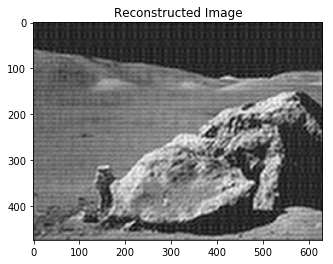

In [5]:
#Step 3
image_new = fftpack.ifft2(image_fft2).real

plt.figure()
plt.imshow(image_new, plt.cm.gray)
plt.title('Reconstructed Image')

## Code behind fftpack
As we further invesigate, 'scipy.fftpack.fft' method uses 'scipy.fftpack.fftn' method which uses the same priciple as we've introduced
in the preivious part. Now let's look at the code details about this method for better understanding of FFT.

### scipy.fftpack.fftn(x, shape=None, axes=None, overwrite_x=False)
It returns multidimensional discrete Fourier transform and the returned array contains:

   y[j_1,..,j_d] = sum[k_1=0..n_1-1, ..., k_d=0..n_d-1]
     x[k_1,..,k_d] * prod[i=1..d] exp(-sqrt(-1)*2*pi/n_i * j_i * k_i), where d = len(x.shape) and n = x.shape.
     
The input parameters contains: 
    1. x : The n dimensional array to transform
    2. shape: "The shape of the result. If both shape and axes (see below) are None, shape is x.shape; if shape is None but axes is not None, then shape is scipy.take(x.shape, axes, axis=0). If shape[i] > x.shape[i], the i-th dimension is padded with zeros. If shape[i] < x.shape[i], the i-th dimension is truncated to length shape[i]. If any element of shape is -1, the size of the corresponding dimension of x is used."
    3. axes: The axes of which transformation applies
    4. overwrite: Whether the contents of x can be destroyed
Return :
    y: The n dimensional discrete fourier transformation of input array
    
References: https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fftn.html#scipy.fftpack.fftn

### References: 

1.https://jakevdp.github.io/blog/2013/08/28/understanding-the-fft/
2.http://www.cs.cmu.edu/afs/andrew/scs/cs/15-463/2001/pub/www/notes/fourier/fourier.pdf
3.https://software.intel.com/en-us/articles/implementation-of-fast-fourier-transform-for-image-processing-in-directx-10
4.https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fftn.html#scipy.fftpack.fftn
5.https://www.youtube.com/watch?v=htCj9exbGo0

### Appendix:
See the buttons below Activities for solutions.
Thank you!